In [1]:
%matplotlib inline
import cvxpy as cvx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .1:
        return "{:.0e}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)

In [3]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = np.round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [13]:
datasets = ["milan", "hepmass", "exponential"]
dataset_paths = {
    "milan": ("../../datasets/internet-mi-2013-11.csv","internet"),
    "exponential": ("../../datasets/exponential_10M.csv","x"),
    "hepmass": ("../../datasets/hepmass_l.csv","f0"),
}
sorted_vals = {}
for d in datasets:
    print(d)
    dpath, dcol = dataset_paths[d]
    df = pd.read_csv(dpath)
    sorted_vals[d] = np.sort(df[dcol])

milan
hepmass
exponential


In [15]:
def process(df, sorted_data, is_int=False):
    df["error"] = df.apply(
        lambda r: get_error(
            sorted_data[r["dataset"]], r["quantile_estimate"], r["q"],
            is_int=is_int
        ),
        axis=1
    )
    return df

In [29]:
df1 = pd.read_csv("../cvxestimate/lesion_results.csv")
df2 = pd.read_csv("../cvxestimate/lesion_solve.csv")
df = pd.concat([df1, df2]).reset_index()
dft = process(df, sorted_vals)

In [30]:
dfg = dft.groupby(["dataset","sketch"]).mean()

In [50]:
sketches = ["gaussian", "mnat", "lp", "mindensity", "maxent", "newton", "clenshaw"]
sketch_display_names = [
    "gaussian", 
    "mnat", 
    "svd", 
    "cvx-min", 
    "cvx-maxent", 
    "newton", 
    "opt"
]

In [52]:
def gen_bar_plot(ax, xlabels, ys, log=False, label=False):
    n = len(ys)
    xlocs = np.arange(0, n)
    ax.bar(
        xlocs,
        height=ys,
        log=log,
    )
    if (label):
        rects = ax.patches
        for rect, label in zip(rects, ys):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width()/2, 
                height,
                human_format(label),
                ha='center', va='bottom', size = 8,
            )
    ax.set_xticks(xlocs)
    ax.set_xticklabels(xlabels, rotation=-55)

In [53]:
l_datasets = ["milan", "hepmass"]

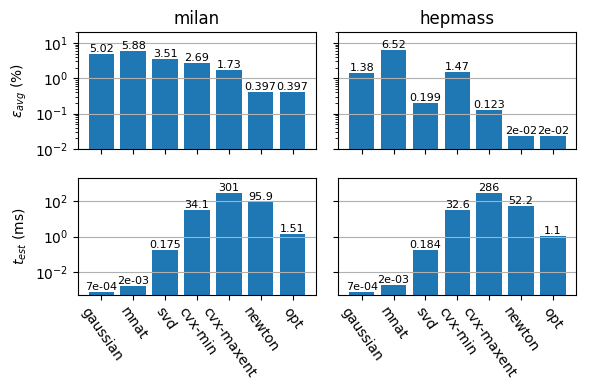

In [54]:
fig, axs = plt.subplots(figsize=(6,4), nrows=2, ncols=2, sharex=True, sharey="row", dpi=100)
for di in range(len(l_datasets)):
    dname = l_datasets[di]
    dtemp = dfg.loc[dname]
    
    ax = axs[0][di]
    ys = []
    for cursketch in sketches:
        ys.append(dtemp.loc[cursketch]["error"])
    ys = np.array(ys)
    gen_bar_plot(ax, sketch_display_names, np.array(ys)*100, log=True, label=True)
    ax.set_ylim(.01, 20)
    if di == 0:
        ax.set_ylabel("$\epsilon_{avg}$ (%)")
    ax.yaxis.grid(True)
    ax.set_title(dname)
    
    ax = axs[1][di]
    ys = []
    for cursketch in sketches:
        ys.append(dtemp.loc[cursketch]["query_time"])
    ys = np.array(ys)
    gen_bar_plot(ax, sketch_display_names, np.array(ys)*1e-6, log=True, label=True)
    ax.set_ylim(.5e-3, 2e3)
    if di == 0:
        ax.set_ylabel("$t_{est}$ (ms)")
    ax.yaxis.grid(True)
#     ax.set_title(dname)

fig.tight_layout()
fig.savefig("lesion.pdf")